### Load packages

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib_venn import venn2
from sklearn.preprocessing import StandardScaler
np.set_printoptions(suppress=True)

### Loading datasets

In [61]:
# Read the directory paths from the text file
with open("Ldirectory.txt", "r") as file:
    lines = file.readlines()
    dailyprice_directory = lines[0].strip().split(":")[1].strip()
    sentiment_directory = lines[1].strip().split(":")[1].strip()

# Open dailyprice and sentiment files using the directory paths
price_data = pd.read_csv(dailyprice_directory)
sentiment_data = pd.read_excel(sentiment_directory, sheet_name=1)

Let's take a preliminary look at the datasets to gain an initial understanding of their contents and structure.

In [62]:
price_data.sample(7)

,date,1. open,2. high,3. low,4. close,5. volume,TickerName
783,2023-02-22,5.0500,5.1900,5.0500,5.160,56167,GCT
1438,2022-08-26,2.6618,2.6618,2.3300,2.470,343256,MGAM
1056,2023-03-27,1.4517,1.4800,1.3900,1.430,14785,SNAL
1022,2023-05-15,1.4400,1.5300,1.4400,1.465,4021,SNAL
748,2023-04-13,5.8500,6.0500,5.8500,5.900,39809,GCT
1354,2022-12-27,1.2100,1.2700,1.0400,1.120,573616,MGAM
557,2023-04-28,0.9000,0.9300,0.8215,0.890,78764,ASST


In [63]:
sentiment_data.sample(7)

,date,News Sentiment
11584,2011-10-08,-0.270918
8739,2003-12-24,0.284860
11616,2011-11-09,-0.164991
2164,1985-12-23,-0.040419
7397,2000-04-21,0.210809
1683,1984-08-29,0.105096
4628,1992-09-21,-0.061812


# Data Preparation

The data preparation phase that we are applying in this project as a part of CRISP-DM process involves several key steps. Initially, **data cleaning** is performed to address issues like missing values, outliers, and inconsistencies, ensuring the dataset is accurate and reliable. Next, **Feature engineering** tasks such as scaling and normalization to modify and restructure the data for better analysis. Finally, the dataset is split into training and testing **(train-test split)**, allowing for unbiased model evaluation and avoiding overfitting. These steps collectively ensure that the data is of high quality, suitable for analysis, and well-prepared for subsequent modeling and evaluation stages.

- Data Cleaning (pre-processing)
- Feature engineering
- Train/Test split

## Data Cleaning (Pre-processing)

- Formatting and type conversion
- Column concatination
- Column selection and dropping
- Missing value analysis
- Rename columns
- Outlier detection
- Duplicate detection


#### Formatting and type conversion

In [64]:
# changing date column to datetime
price_data['date']= pd.to_datetime(price_data['date'])

#### Column concatination

Before starting the data preparation process, let's merge the two datasets based on the 'date' column

In [65]:
joined_df = sentiment_data.set_index('date').join(price_data.set_index('date'), how='inner').reset_index()

#### Column selection and dropping

In this part we are identifying and selecting the columns that are relevant or necessary for our future analysis and modeling.

In [66]:
#Drop specific columns
columns_to_drop = ['2. high', '3. low', '1. open']
joined_df = joined_df.drop(columns=columns_to_drop)

# Print the modified DataFrame
joined_df

,date,News Sentiment,4. close,5. volume,TickerName
0,2022-01-27,-0.048525,5.9100,1608576,KSCP
1,2022-01-28,-0.058983,16.2900,26574308,KSCP
2,2022-01-31,-0.067368,21.4000,42899912,KSCP
3,2022-02-01,-0.070566,12.4400,18493106,KSCP
4,2022-02-02,-0.061209,9.5500,12613046,KSCP
...,...,...,...,...,...
1429,2023-10-13,-0.073652,0.8716,598178,KSCP
1430,2023-10-13,-0.073652,0.5361,502908,ASST
1431,2023-10-13,-0.073652,8.6900,476329,GCT
1432,2023-10-13,-0.073652,1.4000,4298,SNAL


#### Missing value analysis

In [67]:
has_nulls = joined_df.isnull().any().any()

# Check if the dataset has null values
if has_nulls:
    print("The dataset contains null values.")
else:
    print("The dataset does not have any null values.")

The dataset does not have any null values.


Based on the absence of null values in the dataset, the data has been thoroughly examined and found to be free of any missing values. Consequently, we can confidently proceed to the subsequent steps.

#### Rename columns

We are renaming our columns to better reflect the content of our dataset

In [68]:
old_names = ['date', 'News Sentiment', '4. close', '5. volume', 'TickerName']
new_names = ['date', 'News Sentiment', 'close', 'volume']

# Create a mapping dictionary from old names to new names
column_mapping = dict(zip(old_names, new_names))

# Rename the columns using the mapping dictionary
joined_df = joined_df.rename(columns=column_mapping)
joined_df.sample(7)

,date,News Sentiment,close,volume,TickerName
619,2023-02-22,-0.013844,1.0900,607251,KSCP
340,2022-11-14,-0.117618,6.4400,180135,GCT
1262,2023-08-25,-0.020734,1.3100,3937,SNAL
814,2023-04-19,-0.169334,0.6730,993260,KSCP
366,2022-11-22,-0.121982,0.7901,25750,MGAM
70,2022-05-09,-0.067036,4.0300,228230,KSCP
278,2022-10-17,-0.217449,5.6200,394065,GCT


#### Outlier detection

In [69]:
# Select the numerical columns for outlier detection
numeric_cols = ['News Sentiment', 'close', 'volume']

# Compute the Z-scores for each numeric column
z_scores = np.abs((joined_df[numeric_cols] - joined_df[numeric_cols].mean()) / joined_df[numeric_cols].std())

# Set the threshold for outlier detection (e.g., Z-score threshold of 3)
z_score_threshold = 3

# Identify outliers by checking if the Z-score exceeds the threshold
outliers = joined_df[z_scores > z_score_threshold]

# Print the outliers
print(outliers)

     date  News Sentiment  close      volume TickerName
0     NaT             NaN    NaN         NaN        NaN
1     NaT             NaN  16.29  26574308.0        NaN
2     NaT             NaN  21.40  42899912.0        NaN
3     NaT             NaN    NaN  18493106.0        NaN
4     NaT             NaN    NaN         NaN        NaN
...   ...             ...    ...         ...        ...
1429  NaT             NaN    NaN         NaN        NaN
1430  NaT             NaN    NaN         NaN        NaN
1431  NaT             NaN    NaN         NaN        NaN
1432  NaT             NaN    NaN         NaN        NaN
1433  NaT             NaN    NaN         NaN        NaN

[1434 rows x 5 columns]


Given the complexity of the previous output, visualizing the outliers through plotting is a more comprehensible approach. The following code facilitates a clearer understanding of the data by creating a boxplot that highlights outliers.

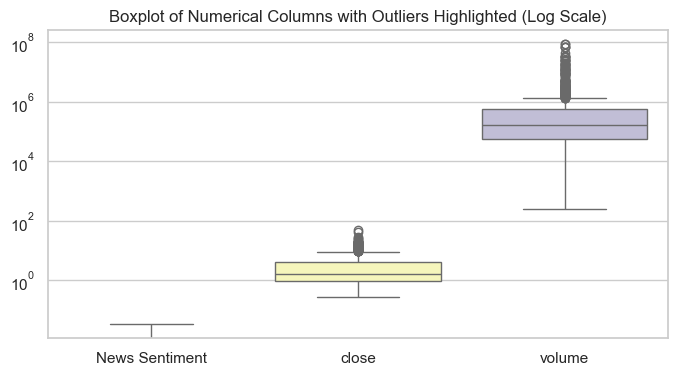

C:\Users\babyl\AppData\Local\Temp\ipykernel_19656\917716136.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




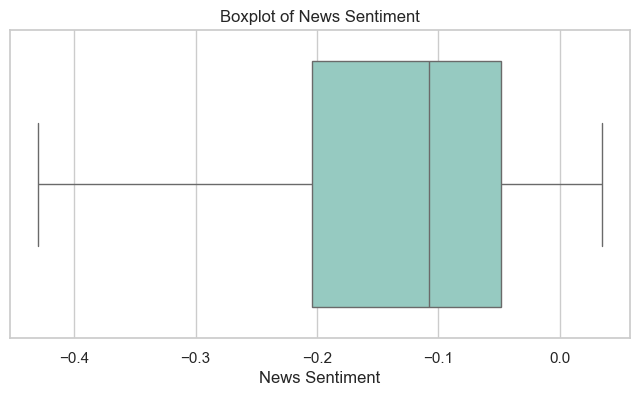

In [70]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a boxplot for each numerical column with log scale on the y-axis
plt.figure(figsize=(8, 4))
sns.boxplot(data=joined_df.drop(columns=['date', 'TickerName']), palette="Set3")
plt.yscale("log")  # Apply logarithmic scale to the y-axis
plt.title("Boxplot of Numerical Columns with Outliers Highlighted (Log Scale)")
plt.show()

# Separate boxplot for 'News Sentiment'
plt.figure(figsize=(8, 4))
sns.boxplot(x=joined_df['News Sentiment'], palette="Set3")
plt.title("Boxplot of News Sentiment")
plt.show()


**Plot interpretation:**
In all of the plots, log scales were used to make the small values more visible. In the first plot, both the close and volume columns have numerous outliers, indicating that some values are extreme. This suggests that the range of 75 percent of the data has a narrower span.

#### Duplicate detection

In [71]:
# Detect duplicates based on all columns
duplicates = joined_df[joined_df.duplicated()]


# Check if duplicates are found
if duplicates.empty:
    print("No duplicates found in the dataset.")
else:
    print("Duplicates in the dataset:")
    print(duplicates)


No duplicates found in the dataset.


Based on the previous output, we can observe that our dataset does not contain any duplicate records. Therefore, we can confidently proceed to the next step of our analysis.

## Feature Engineering

In this section, we will perform tasks such as transforming the values of features that we believe will help improve the performance of the model we are going to use. Our main goal here is to extract relevant information from the data, refine the feature representation, and present it in a way that makes it easier for our models to learn and make accurate predictions. Overall, our aim is to enhance the model's performance by optimizing the features and their representation.

- Mathematical transformation
- scaling numerical features

#### Mathmatical transformation

Here, we are primarily focusing on the 'close price' column, which serves as our dependent variable. Initially, the data is represented in terms of prices. However, for our model and business problem, we require the percentage change on a daily basis. This is where the transformation process becomes useful.

In [72]:
# Calculate the percentage change of the 'close' column
joined_df['close'] = joined_df['close'].pct_change()*100

In [73]:
joined_df.dropna(subset = ['close'], inplace = True)
joined_df.sample(5)

,date,News Sentiment,close,volume,TickerName
256,2022-10-06,-0.234650,39.664804,32582,KSCP
997,2023-06-09,-0.386295,-77.793696,3199,SNAL
67,2022-05-04,-0.063453,-0.671141,150876,KSCP
1305,2023-09-08,-0.024637,-26.247166,9551,ASST
1132,2023-07-20,-0.017263,-76.201923,30912,SNAL


Now, let's visualize the changes we made to our features through the following plots:
 

Line plot: 

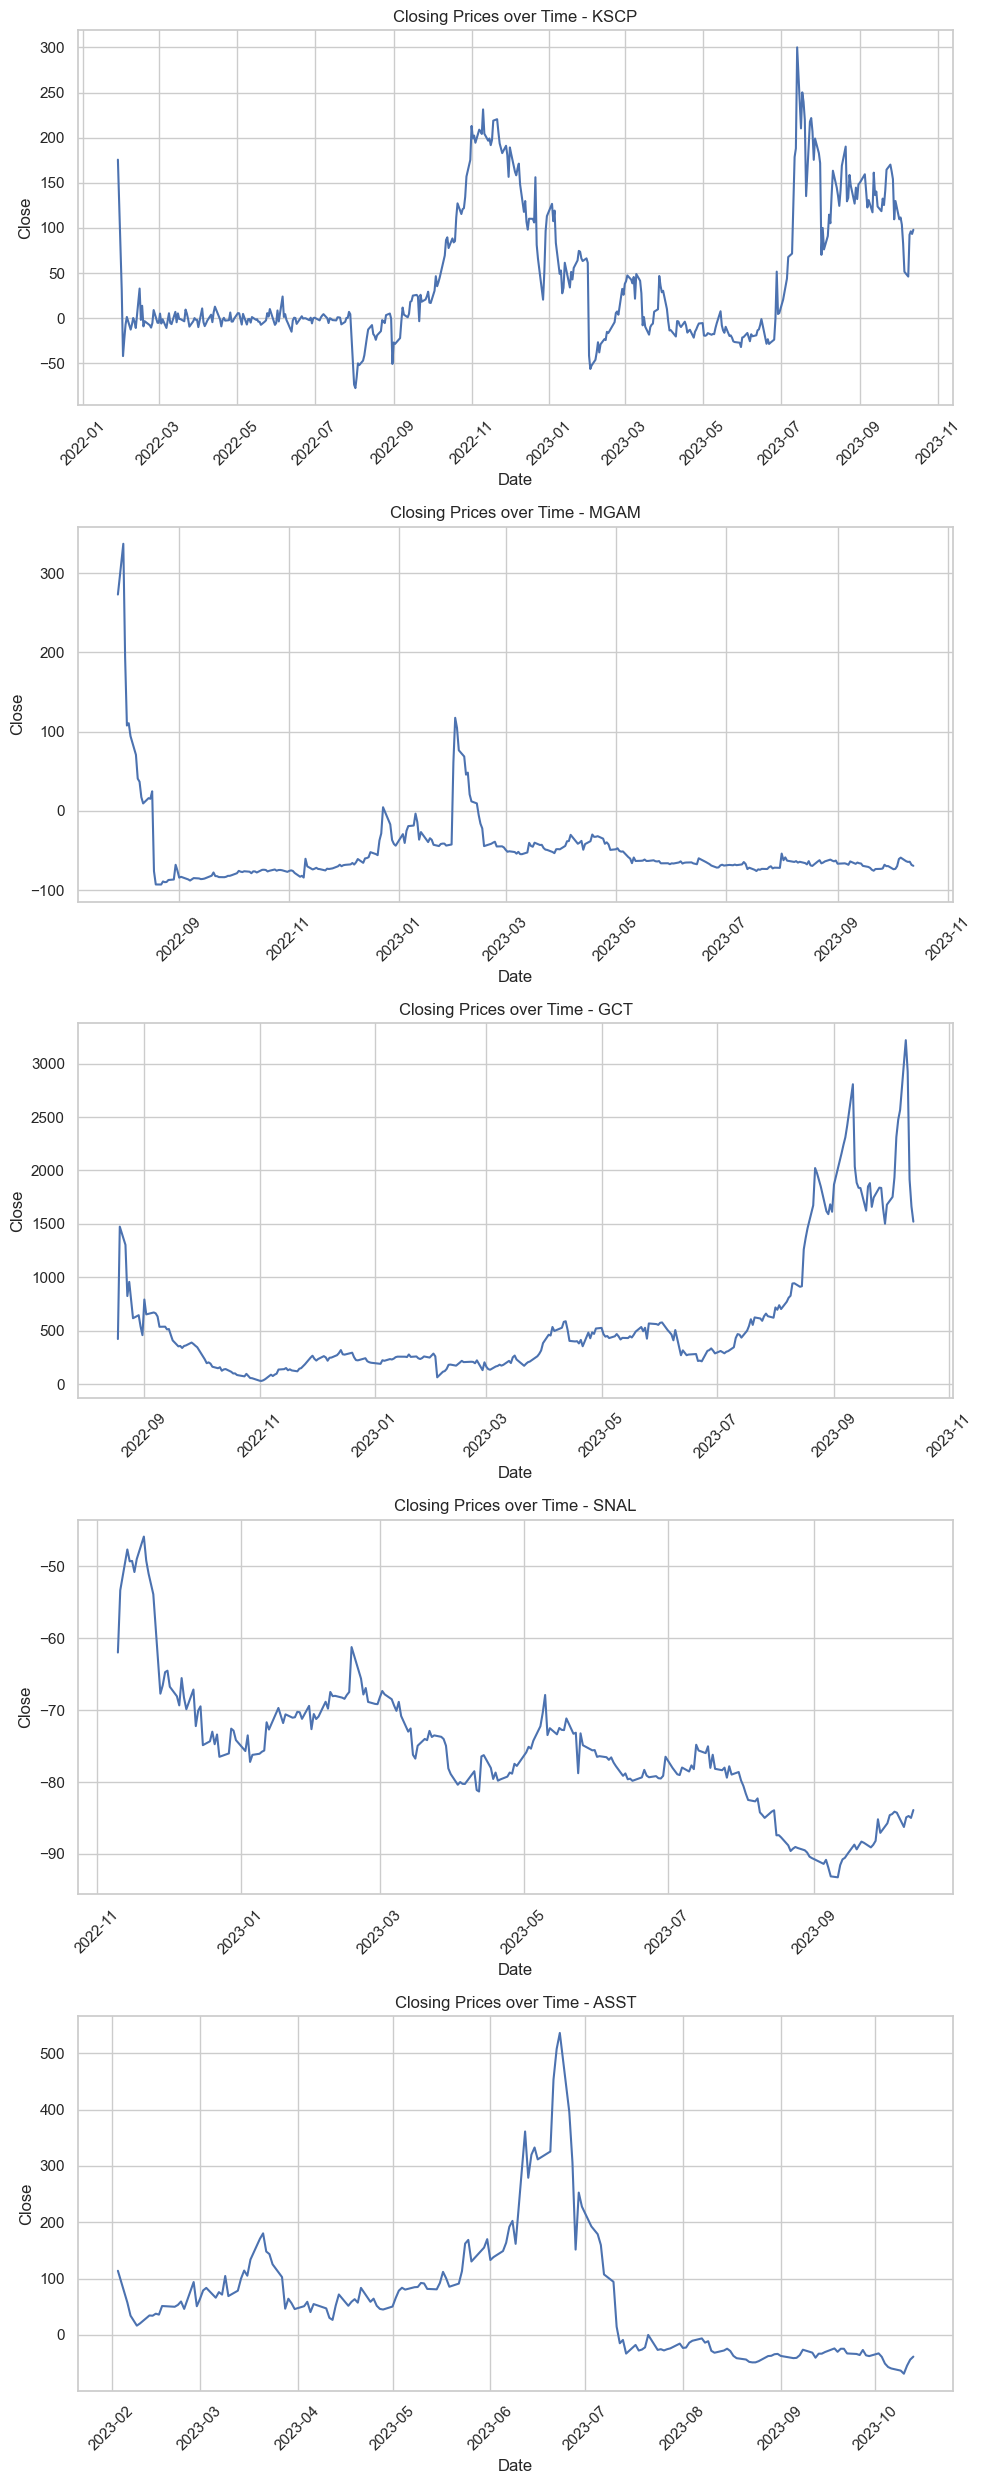

In [74]:
# Get unique tickers from the dataset
tickers = joined_df['TickerName'].unique()

# Set up the subplot layout
num_plots = len(tickers)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5*num_plots))

# Iterate over each ticker and create a subplot for each
for i, ticker in enumerate(tickers):
    # Filter the data by ticker name
    filtered_df = joined_df[joined_df['TickerName'] == ticker]
    
    # Create a line plot for the 'close' column over time
    axes[i].plot(filtered_df['date'], filtered_df['close'])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Close')
    axes[i].set_title(f'Closing Prices over Time - {ticker}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

# Adjust the layout and spacing
plt.tight_layout()

# Display the plots
plt.show()

#### Scaling numerical features

In [75]:
# Extract numerical columns
numerical_cols = joined_df.select_dtypes(include=[np.number]).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standard scaling to the numerical columns
joined_df_scaled = joined_df.copy()
joined_df_scaled[numerical_cols] = scaler.fit_transform(joined_df[numerical_cols])


In [76]:
joined_df_scaled.sample(7)

,date,News Sentiment,close,volume,TickerName
1038,2023-06-22,-1.021894,-0.494114,-0.211916,MGAM
337,2022-11-11,0.103039,-0.456681,3.324942,SNAL
428,2022-12-15,-0.018878,0.445312,-0.195970,GCT
1225,2023-08-16,0.433914,-0.389399,-0.206361,ASST
1342,2023-09-19,0.966183,-0.554120,-0.219762,SNAL
1136,2023-07-21,1.154655,1.378845,-0.171641,GCT
1035,2023-06-22,-1.021894,1.060903,-0.064140,ASST


Let's look at the changes we have made in scaling section through a visualization

In [77]:
# Iterate over each unique ticker
for ticker in joined_df_scaled['TickerName'].unique():
    # Filter the scaled data based on the current ticker
    filtered_data = joined_df_scaled[joined_df_scaled['TickerName'] == ticker]

    # Create a subplot for each numerical column
    fig = make_subplots(rows=len(numerical_cols), cols=1, subplot_titles=numerical_cols)
    
    # Iterate over each numerical column
    for i, col in enumerate(numerical_cols):
        # Create a histogram trace for the current column
        hist_trace = go.Histogram(x=filtered_data[col], nbinsx=15, histnorm='density', name=col)
        
        # Add the histogram trace to the subplot
        fig.add_trace(hist_trace, row=i+1, col=1)
    
    # Update the subplot layout and titles
    fig.update_layout(height=600, width=600, title=f"Histograms of Scaled Numerical Columns for Ticker {ticker}")
    
    # Show the plot
    fig.show()



## Train-Test split

In the data preparation phase, we need to divide our features into two subsets: the training set and the testing set. This division is crucial for evaluating our machine learning model's performance on unseen data. To achieve this, we will use a common practice of splitting the data with a 70/30 proportion, assigning 70% to the training set and 30% to the testing set.

To accomplish this, we will utilize the following code snippet to perform the task of splitting our data into training and testing sets:

In [83]:
# Initialize empty DataFrames for train and test data
train = pd.DataFrame()
test = pd.DataFrame()

# Split data for each unique ticker
for ticker in joined_df_scaled["TickerName"].unique():

    # Filter data for the current ticker
    current_ticker_data = joined_df_scaled[joined_df_scaled["TickerName"] == ticker]
    
    # Perform train-test split for the current ticker data
    train_sub, test_sub = train_test_split(current_ticker_data, test_size=0.3, shuffle=False)
    
    # Concatenate the current ticker train and test data to the overall train and test data
    train = pd.concat([train, train_sub], ignore_index=True)
    test = pd.concat([test, test_sub], ignore_index=True)

In [79]:
# Print the shape of the train set
print(f"Train set shape: {train.shape}")

# Print the shape of the test set
print(f"Test set shape: {test.shape}")

# Calculate and print the ratio of the test set size to the train set size
print(test.shape[0] / train.shape[0])

# Print the latest training date
print(f"Our latest training date is {train['date'].max()}")

Train set shape: (1001, 5)
Test set shape: (432, 5)
0.43156843156843155
Our latest training date is 2023-07-31 00:00:00


In the following bar plot we will show the distribution of samples between the train and test sets, providing a visual representation of the train-test split for tickers.

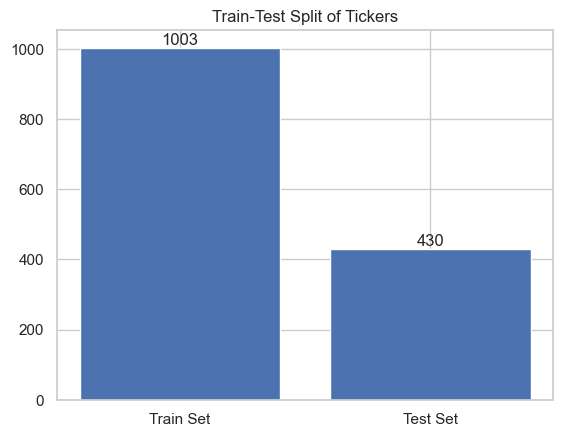

In [86]:
import matplotlib.pyplot as plt

# Calculate the number of samples in the original dataset
total_samples = len(joined_df_scaled)

# Calculate the number of training samples based on the desired train-test split ratio
train_samples = int(total_samples * 0.7)  # 70% for training

# Calculate the number of testing samples
test_samples = total_samples - train_samples

# Create a bar plot to visualize the train-test split
plt.bar(['Train Set', 'Test Set'], [train_samples, test_samples])

# Add labels to the bars
plt.text(0, train_samples, str(train_samples), ha='center', va='bottom')
plt.text(1, test_samples, str(test_samples), ha='center', va='bottom')

# Add a title to the plot
plt.title('Train-Test Split of Tickers')

# Display the plot
plt.show()

Plot interpretation: 
As we can observe in the bar plot that it indicates that the train set contains a larger number of samples compared to the test set, illustrating the train-test split for tickers. 